# GreySheep Identifier and Recommender System

In [ ]:
from pyspark.sql import  SparkSession

spark = SparkSession.builder.appName("GreySheepIdentifier").getOrCreate()

users = spark.read.csv("ITM-Rec/users.csv", header=True, inferSchema=True)

users.show()

24/11/26 23:33:47 WARN Utils: Your hostname, Buffs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.16 instead (on interface en0)
24/11/26 23:33:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/26 23:33:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------+-------+-----+-------+
|UserID| Gender|  Age|Married|
+------+-------+-----+-------+
|  1000|      0|20-25|      0|
|  1001|      1|20-25|      0|
|  1002|      1|26-30|      0|
|  1003|      0|26-30|      1|
|  1004|      0|26-30|      1|
|  1005|      1|20-25|      0|
|  1006|      1|26-30|      0|
|  1007|      0|26-30|      0|
|  1008|      0|20-25|      0|
|  1009|      1|26-30|      0|
|  1010|      0|26-30|      0|
|  1011|      1|20-25|      0|
|  1012|      1|26-30|      0|
|  1013|      1|  >30|      0|
|  1014|      1|26-30|      0|
|  1015|      0|20-25|      0|
|  1016|      0|20-25|      0|
|  1017|      0|20-25|      0|
|  1018|      0|20-25|      0|
|  1019|      1|26-30|      0|
+------+-------+-----+-------+
only showing top 20 rows



In [4]:
items = spark.read.csv("ITM-Rec/items.csv", header=True, inferSchema=True)

items.show(truncate=False)

+----+---------------------------------------+-----------------------------------------------------------------+------------+
|Item|Title                                  |URL                                                              |Descriptions|
+----+---------------------------------------+-----------------------------------------------------------------+------------+
|1   |E-Commerce                             |https://en.wikipedia.org/wiki/Online_shopping                    |NULL        |
|2   |News Website                           |https://en.wikipedia.org/wiki/Online_newspaper                   |NULL        |
|3   |Flight ticket purchase system          |https://en.wikipedia.org/wiki/Airline_reservations_system        |NULL        |
|4   |Inventory management system            |https://en.wikipedia.org/wiki/Inventory_management_software      |NULL        |
|5   |Library (Book Rental and Return) System|https://en.wikipedia.org/wiki/Digital_library                    |NULL  

In [5]:
ratings = spark.read.csv("ITM-Rec/ratings.csv", header=True, inferSchema=True)

ratings.show(truncate=False)

+------+----+------+---+----+----+-----+--------+--------+
|UserID|Item|Rating|App|Data|Ease|Class|Semester|Lockdown|
+------+----+------+---+----+----+-----+--------+--------+
|1173  |28  |5     |4  |4   |4   |DA   |Fall    |PRE     |
|1173  |41  |5     |4  |4   |4   |DA   |Fall    |PRE     |
|1173  |61  |4     |4  |4   |4   |DA   |Fall    |PRE     |
|1173  |22  |1     |1  |2   |2   |DA   |Fall    |PRE     |
|1173  |27  |1     |1  |2   |2   |DA   |Fall    |PRE     |
|1173  |31  |1     |2  |2   |2   |DA   |Fall    |PRE     |
|1151  |21  |4     |4  |5   |4   |DA   |Fall    |PRE     |
|1151  |47  |4     |4  |5   |4   |DA   |Fall    |PRE     |
|1151  |69  |5     |4  |5   |4   |DA   |Fall    |PRE     |
|1151  |28  |2     |2  |1   |2   |DA   |Fall    |PRE     |
|1151  |39  |1     |2  |2   |2   |DA   |Fall    |PRE     |
|1151  |45  |1     |2  |1   |2   |DA   |Fall    |PRE     |
|1324  |21  |3     |5  |5   |4   |DA   |Fall    |PRE     |
|1324  |25  |4     |5  |4   |3   |DA   |Fall    |PRE    

In [6]:
#join dataframes function
def join_dataframes(df1, df2, key, columns=None):
    joined = df1.join(df2, on=key)
    if columns:
        columns = [sub_col for col in columns for sub_col in col.split(",")]
        joined = joined.select(columns)
    return joined

In [7]:

#join user and ratings dataframes
user_ratings = join_dataframes(users, ratings, key="UserID")

user_ratings.show(truncate=False)

+------+-------+-----+-------+----+------+---+----+----+-----+--------+--------+
|UserID| Gender| Age |Married|Item|Rating|App|Data|Ease|Class|Semester|Lockdown|
+------+-------+-----+-------+----+------+---+----+----+-----+--------+--------+
|1173  |0      |26-30|1      |28  |5     |4  |4   |4   |DA   |Fall    |PRE     |
|1173  |0      |26-30|1      |41  |5     |4  |4   |4   |DA   |Fall    |PRE     |
|1173  |0      |26-30|1      |61  |4     |4  |4   |4   |DA   |Fall    |PRE     |
|1173  |0      |26-30|1      |22  |1     |1  |2   |2   |DA   |Fall    |PRE     |
|1173  |0      |26-30|1      |27  |1     |1  |2   |2   |DA   |Fall    |PRE     |
|1173  |0      |26-30|1      |31  |1     |2  |2   |2   |DA   |Fall    |PRE     |
|1151  |0      |26-30|0      |21  |4     |4  |5   |4   |DA   |Fall    |PRE     |
|1151  |0      |26-30|0      |47  |4     |4  |5   |4   |DA   |Fall    |PRE     |
|1151  |0      |26-30|0      |69  |5     |4  |5   |4   |DA   |Fall    |PRE     |
|1151  |0      |26-30|0     

In [8]:
from pyspark.sql.functions import stddev, mean, collect_list

def getStats(stats_df, rating_type, deviation_limit):
   rating = stats_df.groupBy("UserID")\
          .agg(mean(rating_type).alias(f"avg_{rating_type.lower()}"), 
               stddev(rating_type).alias(f"{rating_type.lower()}_stddev"), 
               collect_list(rating_type).alias(f"{rating_type.lower()}_list"),
     )
   
   filter = f"{rating_type.lower()}_stddev > {deviation_limit}" 
   return rating.filter(filter)

overall_rating_stats = getStats(ratings, "Rating", 2)
app_rating_stats = getStats(ratings,"App", 2)
data_rating_stats = getStats(ratings,"Data", 2)
ease_rating_stats = getStats(ratings,"Ease",1.7)

stats = [overall_rating_stats, app_rating_stats, data_rating_stats, ease_rating_stats]

for i in range(len(stats)):
    stats[i].show(10, truncate=False)


+------+------------------+------------------+------------------------------------+
|UserID|avg_rating        |rating_stddev     |rating_list                         |
+------+------------------+------------------+------------------------------------+
|1011  |2.8333333333333335|2.041241452319315 |[4, 5, 5, 1, 1, 1]                  |
|1048  |3.1666666666666665|2.041241452319315 |[5, 5, 5, 2, 1, 1]                  |
|1099  |3.1666666666666665|2.041241452319315 |[5, 5, 5, 1, 2, 1]                  |
|1125  |3.142857142857143 |2.0354009783964297|[4, 5, 5, 5, 1, 1, 1]               |
|1216  |3.0               |2.1908902300206643|[5, 5, 5, 1, 1, 1]                  |
|1222  |3.5               |2.070196678027062 |[5, 5, 5, 5, 5, 1, 1, 1]            |
|1239  |3.0               |2.088931871468374 |[5, 5, 5, 1, 1, 1, 5, 5, 5, 1, 1, 1]|
|1275  |3.0               |2.1908902300206643|[5, 5, 5, 1, 1, 1]                  |
|1298  |3.1666666666666665|2.041241452319315 |[5, 5, 5, 1, 2, 1]            

In [9]:
user_item_ratings = join_dataframes(user_ratings, items, key="Item")

user_item_ratings.show(truncate=False)

+----+------+-------+-----+-------+------+---+----+----+-----+--------+--------+-------------------------------------------+---------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:

# Split the ratings DataFrame into 90% training and 10% test
set = user_item_ratings.randomSplit([0.9, 0.1], seed=12345)

training = set[0].cache()


training.show(10, truncate=False)

test = set[1].cache()

test.show(5, truncate=False)

print(f"Training: {training.count()}, Test: {test.count()}")

+----+------+-------+-----+-------+------+---+----+----+-----+--------+--------+-----------+---------------------------------------------+------------+
|Item|UserID| Gender| Age |Married|Rating|App|Data|Ease|Class|Semester|Lockdown|Title      |URL                                          |Descriptions|
+----+------+-------+-----+-------+------+---+----+----+-----+--------+--------+-----------+---------------------------------------------+------------+
|1   |1005  |1      |20-25|0      |4     |4  |4   |3   |DB   |Fall    |POS     |E-Commerce |https://en.wikipedia.org/wiki/Online_shopping|NULL        |
|1   |1008  |0      |20-25|0      |5     |4  |3   |3   |DB   |Fall    |POS     |E-Commerce |https://en.wikipedia.org/wiki/Online_shopping|NULL        |
|1   |1009  |1      |26-30|0      |3     |2  |3   |1   |DB   |Fall    |POS     |E-Commerce |https://en.wikipedia.org/wiki/Online_shopping|NULL        |
|1   |1015  |0      |20-25|0      |4     |4  |3   |3   |DB   |Fall    |POS     |E-Commer

In [92]:
from pyspark.ml.recommendation import ALS

# Define ALS model parameters
rank = 40
num_iterations = 15
regularization = 0.09

# Initialize ALS
als = ALS(
    rank=rank,
    maxIter=num_iterations,
    regParam=regularization,
    userCol="UserID",
    itemCol="Item",
    ratingCol="Rating",
    coldStartStrategy="drop" 
)

model = als.fit(training)

# Model type
print(type(model))

<class 'pyspark.ml.recommendation.ALSModel'>


In [93]:

user_item_ratings = user_item_ratings.dropna()  # Remove rows with any NaN values
user_item_ratings = user_item_ratings.select("UserID","Item", "Rating", "Title", "URL") 
user_item_ratings.show(truncate=False)

+------+----+------+-------------------------------------------+---------------------------------------------------------------------------------+
|UserID|Item|Rating|Title                                      |URL                                                                              |
+------+----+------+-------------------------------------------+---------------------------------------------------------------------------------+
|1173  |28  |5     |Nutrition Facts for McDonald's Menu        |https://www.kaggle.com/datasets/mcdonalds/nutrition-facts                        |
|1173  |41  |5     |Amazon Fine Food Reviews                   |https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews                    |
|1173  |61  |4     |Video Game Sales                           |https://www.kaggle.com/datasets/gregorut/videogamesales                          |
|1173  |22  |1     |Congress Trump Score                       |https://www.kaggle.com/datasets/fivethirtyeight/trump-

In [94]:
predictions = model.transform(test)

predictions= predictions.select("UserID", 'Item', 'Rating', 'Title', 'URL', 'prediction')

predictions.show(10, truncate=False)

+------+----+------+-----------------------------------------+---------------------------------------------------------------------------------+----------+
|UserID|Item|Rating|Title                                    |URL                                                                              |prediction|
+------+----+------+-----------------------------------------+---------------------------------------------------------------------------------+----------+
|1088  |24  |5     |The Bachelor contestants                 |https://www.kaggle.com/datasets/brianbgonz/the-bachelor-contestants              |4.024217  |
|1238  |26  |1     |Human Resources Analytics                |https://www.kaggle.com/code/jacksonchou/hr-analytics                             |3.468657  |
|1088  |49  |5     |H-1B Visa Petitions 2011-2016            |https://www.kaggle.com/datasets/nsharan/h-1b-visa                                |3.9387314 |
|1342  |53  |2     |Brazil's House of Deputies Reimbursements|ht

In [95]:
#evauating our model 
from pyspark.ml.evaluation import RegressionEvaluator


evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)

print(f"Root-mean-square error = {rmse}")


Root-mean-square error = 1.2751985271337116


+------+------------------+------------------+------------------------------------+
|UserID|avg_rating        |rating_stddev     |rating_list                         |
+------+------------------+------------------+------------------------------------+
|1099  |3.1666666666666665|2.041241452319315 |[5, 5, 5, 1, 2, 1]                  |
|1125  |3.142857142857143 |2.0354009783964297|[4, 5, 5, 5, 1, 1, 1]               |
|1215  |3.1666666666666665|2.041241452319315 |[5, 5, 5, 1, 2, 1]                  |
|1216  |3.0               |2.1908902300206643|[5, 5, 5, 1, 1, 1]                  |
|1223  |2.8333333333333335|2.041241452319315 |[5, 4, 5, 1, 1, 1]                  |
|1239  |3.0               |2.088931871468374 |[5, 5, 5, 1, 1, 1, 5, 5, 5, 1, 1, 1]|
|1275  |3.0               |2.1908902300206643|[5, 5, 5, 1, 1, 1]                  |
|1298  |3.1666666666666665|2.041241452319315 |[5, 5, 5, 1, 2, 1]                  |
|1321  |2.7142857142857144|2.138089935299395 |[5, 5, 5, 1, 1, 1, 1]         

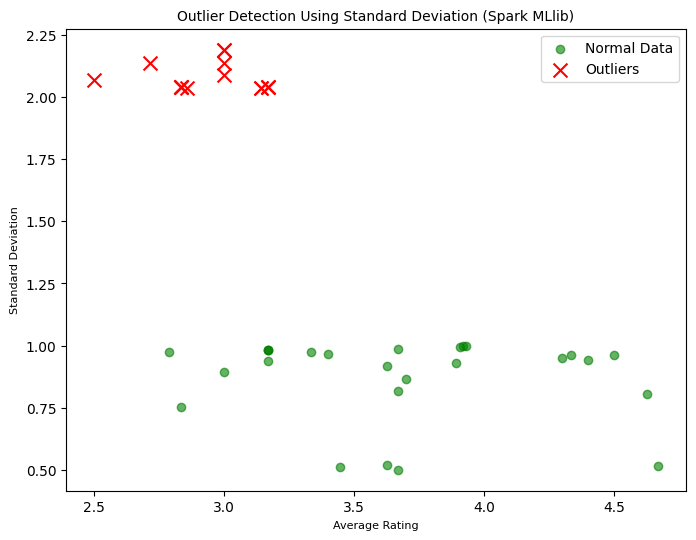

In [96]:
import matplotlib.pyplot as plt


normal_users = getStats(user_item_ratings,'Rating', 0)
outliers = getStats(user_item_ratings,'Rating', 2)

normal_users = normal_users.filter("rating_stddev < 1")

outliers.show(truncate=False)
normal_users.show(truncate=False)

normal_users_df = normal_users.toPandas()
outliers_df = outliers.toPandas()

# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(normal_users_df['avg_rating'], normal_users_df['rating_stddev'], c='green', label='Normal Data', alpha=0.6)

plt.scatter(outliers_df['avg_rating'], outliers_df['rating_stddev'], c='red', marker='x', s=100, label='Outliers')

plt.title("Outlier Detection Using Standard Deviation (Spark MLlib)", fontsize=10)
plt.xlabel("Average Rating", fontsize=8)
plt.ylabel("Standard Deviation", fontsize=8)

# Show the legend
plt.legend()
plt.show() 


In [97]:
#make recommendations for outliers
from pyspark.sql.functions import explode, col


outliers = outliers.select(als.getUserCol()).distinct().limit(5)

# # Generate top 10 recommendations for outliers
outlier_recommendations = model.recommendForUserSubset(outliers, numItems=10)
outlier_recommendations = outlier_recommendations.select(col("UserID"), explode(col("recommendations").alias("recommendation"))) \
.select(col("UserID"),
        col("col.Item").alias("ItemID"),
        col("col.Rating").alias("Predicted_rating")
       )

outlier_recommendations = join_dataframes(outlier_recommendations, items, key=outlier_recommendations["ItemID"] == items["Item"], columns=["UserID", "Item", "Title", "URL", 'Predicted_rating']) 

outlier_recommendations.show(truncate=False)


+------+----+-----------------------------------------------+----------------------------------------------------------------------------------+----------------+
|UserID|Item|Title                                          |URL                                                                               |Predicted_rating|
+------+----+-----------------------------------------------+----------------------------------------------------------------------------------+----------------+
|1352  |21  |Credit Card Fraud Detection                    |https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud                           |4.6647577       |
|1352  |47  |Human Activity Recognition with Smartphones    |https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones |4.5855727       |
|1352  |57  |Emotion; Aging; and Sentiment Over Time        |https://www.kaggle.com/datasets/cjroth/chronist                                   |4.32097         |
|1352  |60  |World Happiness

In [ ]:
spark.stop()